# CS579: Lecture 13  

**Demographic Inference II**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

## Gender Classification

Let's build a classifier to predict whether a Twitter user is male/female.

We'll collect "labeled" training data using Census name list.

**1.) Collect Census names. **

In [55]:
# Fetch male/female names from Census.

import requests

def get_census_names():
    """ Fetch a list of common male/female names from the census.
    For ambiguous names, we select the more frequent gender."""
    males = requests.get('http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first').text.split('\n')
    females = requests.get('http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first').text.split('\n')
    males_pct = dict([(m.split()[0].lower(), float(m.split()[1]))
                  for m in males if m])
    females_pct = dict([(f.split()[0].lower(), float(f.split()[1]))
                    for f in females if f])
    male_names = set([m for m in males_pct if m not in females_pct or
                  males_pct[m] > females_pct[m]])
    female_names = set([f for f in females_pct if f not in males_pct or
                  females_pct[f] > males_pct[f]])    
    return male_names, female_names

male_names, female_names = get_census_names()
print('found %d female and %d male names' % (len(female_names), len(male_names)))
print('male name sample:', list(male_names)[:5])
print('female name sample:', list(female_names)[:5])

found 4014 female and 1146 male names
male name sample: ['stephen', 'mark', 'sammy', 'thanh', 'wallace']
female name sample: ['marion', 'regena', 'kathryne', 'ashely', 'rosanna']


**2.) Sample 5K tweets with names on the Census list. **

In [3]:
# Construct TwitterAPI object.

import configparser
from TwitterAPI import TwitterAPI

def get_twitter(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')

In [4]:
# Sample U.S. tweets with names from Census. 
import sys

def get_first_name(tweet):
    if 'user' in tweet and 'name' in tweet['user']:
        parts = tweet['user']['name'].split()
        if len(parts) > 0:
            return parts[0].lower()

def sample_tweets(twitter, limit, male_names, female_names):
    tweets = []
    while True:
        try:
            # Restrict to U.S.
            for response in twitter.request('statuses/filter',
                        {'locations':'-124.637,24.548,-66.993,48.9974'}):
                if 'user' in response:
                    name = get_first_name(response)
                    if name in male_names or name in female_names:
                        tweets.append(response)
                        if len(tweets) % 100 == 0:
                            print('found %d tweets' % len(tweets))
                        if len(tweets) >= limit:
                            return tweets
        except:
            print("Unexpected error:", sys.exc_info()[0])
    return tweets
        
tweets = sample_tweets(twitter, 5000, male_names, female_names)

found 100 tweets
found 200 tweets
found 300 tweets
found 400 tweets
found 500 tweets
found 600 tweets
found 700 tweets
found 800 tweets
found 900 tweets
found 1000 tweets
found 1100 tweets
found 1200 tweets
found 1300 tweets
found 1400 tweets
found 1500 tweets
found 1600 tweets
found 1700 tweets
found 1800 tweets
found 1900 tweets
found 2000 tweets
found 2100 tweets
found 2200 tweets
found 2300 tweets
found 2400 tweets
found 2500 tweets
found 2600 tweets
found 2700 tweets
found 2800 tweets
found 2900 tweets
found 3000 tweets
found 3100 tweets
found 3200 tweets
found 3300 tweets
found 3400 tweets
found 3500 tweets
found 3600 tweets
found 3700 tweets
found 3800 tweets
found 3900 tweets
found 4000 tweets
found 4100 tweets
found 4200 tweets
found 4300 tweets
found 4400 tweets
found 4500 tweets
found 4600 tweets
found 4700 tweets
found 4800 tweets
found 4900 tweets
found 5000 tweets


In [3]:
# optionally read from disk
# import pickle
# tweets = pickle.load(open('tweets.pkl', 'rb'))

In [5]:
from collections import Counter

print('sampled %d tweets' % len(tweets))
print('top names:', Counter(get_first_name(t) for t in tweets).most_common(10))

sampled 5000 tweets
top names: [('michael', 63), ('mike', 60), ('david', 57), ('matt', 48), ('chris', 48), ('john', 46), ('joe', 40), ('ryan', 39), ('mark', 38), ('brian', 35)]


In [6]:
# Save these tweets.
import pickle
pickle.dump(tweets, open('tweets.pkl', 'wb'))

**3.) Tokenize tweets. **

In [42]:
test_tweet = tweets[1]
print('test tweet:\n\tscreen_name=%s\n\tname=%s\n\tdescr=%s\n\ttext=%s' %
      (test_tweet['user']['screen_name'],
       test_tweet['user']['name'],
       test_tweet['user']['description'],
       test_tweet['text']))

test tweet:
	screen_name=mickeystrand
	name=Mickey Strand
	descr=Portrait Photographer, Beyond the Cut portrait project, WW2 Portrait project, Instructor & Mentor. Retired Navy Combat Camera Chief.
	text=Working on upcoming course description for a Moab fine art shooting intense workshop.


In [43]:
import re

def tokenize(string, lowercase, keep_punctuation, prefix,
             collapse_urls, collapse_mentions):
    """ Split a tweet into tokens."""
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    if prefix:
        tokens = ['%s%s' % (prefix, t) for t in tokens]
    return tokens

In [59]:
tokenize(test_tweet['user']['description'], lowercase=True,
         keep_punctuation=False, prefix='d=',
         collapse_urls=True, collapse_mentions=True)

['d=portrait',
 'd=photographer',
 'd=beyond',
 'd=the',
 'd=cut',
 'd=portrait',
 'd=project',
 'd=ww2',
 'd=portrait',
 'd=project',
 'd=instructor',
 'd=mentor',
 'd=retired',
 'd=navy',
 'd=combat',
 'd=camera',
 'd=chief']

In [58]:
tokenize('apple-banana went to the store!', lowercase=True,
         keep_punctuation=False, prefix='d=',
         collapse_urls=True, collapse_mentions=True)

['d=apple', 'd=banana', 'd=went', 'd=to', 'd=the', 'd=store']

In [18]:
tokenize(test_tweet['text'], lowercase=True, keep_punctuation=True,
         prefix='t=',
         collapse_urls=True, collapse_mentions=False)

['t=working',
 't=on',
 't=upcoming',
 't=course',
 't=description',
 't=for',
 't=a',
 't=moab',
 't=fine',
 't=art',
 't=shooting',
 't=intense',
 't=workshop.']

In [19]:
def tweet2tokens(tweet, use_descr=True, lowercase=True,
                 keep_punctuation=True, descr_prefix='d=',
                 collapse_urls=True, collapse_mentions=True):
    """ Convert a tweet into a list of tokens, from the tweet text and optionally the
    user description. """
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation, None,
                       collapse_urls, collapse_mentions)
    if use_descr:
        tokens.extend(tokenize(tweet['user']['description'], lowercase,
                               keep_punctuation, descr_prefix,
                               collapse_urls, collapse_mentions))
    return tokens

In [60]:
tweet2tokens(test_tweet)

['working',
 'on',
 'upcoming',
 'course',
 'description',
 'for',
 'a',
 'moab',
 'fine',
 'art',
 'shooting',
 'intense',
 'workshop.',
 'd=portrait',
 'd=photographer,',
 'd=beyond',
 'd=the',
 'd=cut',
 'd=portrait',
 'd=project,',
 'd=ww2',
 'd=portrait',
 'd=project,',
 'd=instructor',
 'd=&',
 'd=mentor.',
 'd=retired',
 'd=navy',
 'd=combat',
 'd=camera',
 'd=chief.']

In [20]:
# for enumerating all possible arguments of tweet2tokens
# https://docs.python.org/2/library/itertools.html#itertools.product
from itertools import product

use_descr_opts = [True, False]
lowercase_opts = [True, False]
keep_punctuation_opts = [True, False]
descr_prefix_opts = ['d=', '']
url_opts = [True, False]
mention_opts = [True, False]

argnames = ['use_descr', 'lower', 'punct', 'prefix', 'url', 'mention']
option_iter = product(use_descr_opts, lowercase_opts,
                       keep_punctuation_opts,
                       descr_prefix_opts, url_opts,
                       mention_opts)
for options in option_iter:
    print('  '.join('%s=%s' % (name, opt) 
                    for name, opt in zip(argnames, options)))
    print
    print('  '.join(tweet2tokens(test_tweet, *options)), '\n----\n')

use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=True
working  on  upcoming  course  description  for  a  moab  fine  art  shooting  intense  workshop.  d=portrait  d=photographer,  d=beyond  d=the  d=cut  d=portrait  d=project,  d=ww2  d=portrait  d=project,  d=instructor  d=&  d=mentor.  d=retired  d=navy  d=combat  d=camera  d=chief. 
----

use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=False
working  on  upcoming  course  description  for  a  moab  fine  art  shooting  intense  workshop.  d=portrait  d=photographer,  d=beyond  d=the  d=cut  d=portrait  d=project,  d=ww2  d=portrait  d=project,  d=instructor  d=&  d=mentor.  d=retired  d=navy  d=combat  d=camera  d=chief. 
----

use_descr=True  lower=True  punct=True  prefix=d=  url=False  mention=True
working  on  upcoming  course  description  for  a  moab  fine  art  shooting  intense  workshop.  d=portrait  d=photographer,  d=beyond  d=the  d=cut  d=portrait  d=project,  d=ww2  d=portrai

In [21]:
# Let's tokenize all tweets.
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=False, descr_prefix='d=',
                            collapse_urls=True, collapse_mentions=True)
              for t in tweets]

In [24]:
tokens_list[1]

['working',
 'on',
 'upcoming',
 'course',
 'description',
 'for',
 'a',
 'moab',
 'fine',
 'art',
 'shooting',
 'intense',
 'workshop',
 'd=portrait',
 'd=photographer',
 'd=beyond',
 'd=the',
 'd=cut',
 'd=portrait',
 'd=project',
 'd=ww2',
 'd=portrait',
 'd=project',
 'd=instructor',
 'd=mentor',
 'd=retired',
 'd=navy',
 'd=combat',
 'd=camera',
 'd=chief']

In [68]:
from collections import defaultdict
d = defaultdict(lambda: [])
d['cat'].append(10)
d['cat']
#v = {}
#v['cat'].append(10)

[10]

In [25]:
# Store these in a sparse matrix.

#1) Create a vocabulary (dict from term->index)

# https://docs.python.org/2/library/collections.html#collections.defaultdict
from collections import defaultdict

def make_vocabulary(tokens_list):
    vocabulary = defaultdict(lambda: len(vocabulary))  # If term not present, assign next int.
    for tokens in tokens_list:
        for token in tokens:
            vocabulary[token]  # looking up a key; defaultdict takes care of assigning it a value.
    print('%d unique terms in vocabulary' % len(vocabulary))
    return vocabulary

In [26]:
vocabulary = make_vocabulary(tokens_list)

20234 unique terms in vocabulary


In [27]:
# term->index
list(vocabulary.items())[:10]

[('what', 0),
 ('THIS_IS_A_URL', 1),
 ('d=god', 2),
 ('d=the', 3),
 ('d=jonas', 4),
 ('d=brothers', 5),
 ('d=hold', 6),
 ('d=a', 7),
 ('d=special', 8),
 ('d=place', 9)]

In [28]:
# How big is vocabulary if we keep punctuation?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=True, collapse_mentions=True)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

29731 unique terms in vocabulary


In [29]:
# How big is vocabulary if we keep punctuation and urls?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=False, collapse_mentions=True)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

32591 unique terms in vocabulary


In [30]:
# How big is vocabulary if we keep punctuation and urls and mentions?
tokens_list = [tweet2tokens(t, use_descr=True, lowercase=True,
                            keep_punctuation=True, descr_prefix='d=',
                            collapse_urls=False, collapse_mentions=False)
              for t in tweets]

vocabulary = make_vocabulary(tokens_list)

36909 unique terms in vocabulary


## Feature Vector Matrix

Create a matrix $X$ where $X[i,j]$ is the frequency of term $j$ in tweet $i$.

$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\end{pmatrix}
$$



## Sparse Matrices

$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\end{pmatrix}
$$

$X$ is mostly $0$ for text problems.

## List of List (LIL) Matrix

Store a linked list of (index, value) pairs for each row.

$$
X = \begin{pmatrix}
\hbox{tweet}_1 & (0, 1)\\
\hbox{tweet}_2 & (3,2)\\
\hbox{tweet}_3 & (0,1), (1,1)\\
\end{pmatrix}
$$

**Advantage:** Fast to construct: append to list in constant time.

**Disadvantage:** Slow random access for matrix-vector product.

E.g., $\hat{z} = X\cdot \hat{\beta}$ to classify tweets using a learned weight vector $\beta$

$\hat{z}[i] = \sum_j X[i,j] * \beta[j]$

## Compressed Sparse Row (CSR) Matrix


$$
X = \begin{pmatrix}
~ & \hbox{term}_1 & \hbox{term}_2 & \hbox{term}_3 & \hbox{term}_4 \\
\hbox{tweet}_1 & 1  &  0  &  0 & 0 \\
\hbox{tweet}_2 & 0  &  0  &  0 & 2 \\
\hbox{tweet}_3 & 1  &  1  &  0 & 0 \\
\hbox{tweet}_4 & 1  &  0  &  0 & 0 \\
\end{pmatrix}
$$

CSR Matrix is an object with three attributes: 
- **val:** $\{1,2,1,1,1\}$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *list of all non-zero values*  
- **col_ind:** $\{0,3,0,1,0\}$ &nbsp; *column index for each non-zero value* (e.g., first non-zero value (1) is in column 0) 
- **row_ptr:** $\{0,1,2,4\}$ &nbsp;&nbsp;&nbsp; *index into **col_ind** where each row starts* (e.g., tweet3, term1 corresponds to col_ind[2])

Allows efficient row access (good for us, since each row is a tweet)

In [31]:
# Convert features to a sparse matrix X.
# X[i,j] is the frequency of term j in tweet i
# 
from scipy.sparse import lil_matrix

def make_feature_matrix(tokens_list, vocabulary):
    X = lil_matrix((len(tweets), len(vocabulary)))
    for i, tokens in enumerate(tokens_list):
        for token in tokens:
            j = vocabulary[token]
            X[i,j] += 1
    return X.tocsr()  # convert to CSR for more efficient random access.

In [32]:
X = make_feature_matrix(tokens_list, vocabulary)
print('shape of X:', X.shape)

shape of X: (5000, 36909)


In [67]:
help(X)

Help on csr_matrix in module scipy.sparse.csr object:

class csr_matrix(scipy.sparse.compressed._cs_matrix, scipy.sparse.sputils.IndexMixin)
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
 |          corresponding value

In [71]:
# How is tweet stored?
X[1]

<1x36909 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [37]:
help(X[1].nonzero)

Help on method nonzero in module scipy.sparse.base:

nonzero() method of scipy.sparse.csr.csr_matrix instance
    nonzero indices
    
    Returns a tuple of arrays (row,col) containing the indices
    of the non-zero elements of the matrix.
    
    Examples
    --------
    >>> from scipy.sparse import csr_matrix
    >>> A = csr_matrix([[1,2,0],[0,0,3],[4,0,5]])
    >>> A.nonzero()
    (array([0, 0, 1, 2, 2]), array([0, 1, 2, 0, 2]))



In [72]:
X[1].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0], dtype=int32),
 array([ 4, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], dtype=int32))

In [39]:
# non-zero indices of terms used in tweet 1.
X[1].nonzero()[1]  # col_ind

array([ 4, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], dtype=int32)

In [44]:
# term counts for tweet 1.
X[1].data  # "val"

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [76]:
# What word does each term index correspond to?
# Convert term->index dict into index->term dict
index2term = {i: t for t, i in vocabulary.items()}
print(index2term[15])
print(X[1, 15])
# So, the term "for" (index 29) appears in user 200's tweet two times

d=&
1.0


In [77]:
# d=and appears one time.
print(index2term[46])
print(X[1, 46])

d=cut
1.0


How do CSR matrices access row values?

Recall:

CSR Matrix is an object with three attributes: 
- **val:** $\{1,2,1,1\}$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *list of all non-zero values*  
- **col_ind:** $\{0,3,0,1\}$ &nbsp; *column index for each non-zero value* (e.g., first non-zero value (1) is in column 0) 
- **row_ptr (ind_ptr):** $\{0,1,2\}$ &nbsp;&nbsp;&nbsp; *index into **col_ind** where each row starts* (e.g., tweet3, term1 corresponds to col_ind[2])

In [53]:
# Recall: numpy array slices.
import numpy as np
a = np.array([0, 100, 200, 300, 400, 500])
a[2:5]  # get elements at positions 2,3,4

array([200, 300, 400])

In [79]:
print('tweet 1 starts at col_ind=', X.indptr[1])
print('tweet 2 starts at col_ind=', X.indptr[2])
print('so, the columns that are non-zero for tweet 1 are:')
print(X.indices[X.indptr[1]:X.indptr[2]])
print('and the data associated with those cells are:')
print(X.data[X.indptr[1]:X.indptr[2]])

tweet 1 starts at col_ind= 30
tweet 2 starts at col_ind= 58
so, the columns that are non-zero for tweet 1 are:
[ 4 15 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55]
and the data associated with those cells are:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  3.  1.  1.
  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.]


In [80]:
print('tweet 0:\n', X[0], '\n')
print('tweet 1:\n', X[1], '\n')
print('tweet 2:\n', X[2])

tweet 0:
   (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	2.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	1.0 

tweet 1:
   (0, 4)	1.0
  (0, 15)	1.0
  (0, 30)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 33)	1.0
  (0, 34)	1.0
  (0, 35)	1.0
  (0, 36)	1.0
  (0, 37)	1.0
  (0, 38)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 43)	3.0
  (0, 44)	1.0
  (0, 45)	1.0
  (0, 46)	1.0
  (0, 47)	2.0
  (0, 48)	1.0
  (0, 49)	1.0
  (0, 50)	1.0
  (0, 51)	1.0
  (0, 52)	1.0
  (0, 53)	1.0
  (0, 54)	1.0
  (0, 55)	1.0 

tweet 2:
   (0, 56)	1.0
  (0, 57)	1.0
  (0, 58)	1.0
  (0, 59)	1.0
  (0, 60)	1.0
  (0, 61)	2.0
  (0, 62)	2.0
  (0, 63)	1.0
  (0, 64)	1.0
  (0, 65)	1.0
  (0, 66)	1.0
  (0, 67)	1

**Efficient matrix vector product:**

$$ z = X * \beta $$

In [82]:
# Compute z = X * \beta, where X is a CSR matrix.
import numpy as np
beta = np.ones(len(vocabulary))  # assume Beta = vector of 1s
z = np.zeros(len(tweets))
for i in range(len(tweets)):  # for each row.
    for j in range(X.indptr[i], X.indptr[i+1]): # for each col.
        colidx = X.indices[j]
        z[i] += beta[colidx] * X.data[j]
print('X * beta for tweet 1=', z[1])
print('which is the same as the sum %.1f, since beta=[1...1]' %
      X[1].sum())

X * beta for tweet 1= 31.0
which is the same as the sum 31.0, since beta=[1...1]


**4.) Create a list of gender labels.**

In [85]:
# y is a 1d numpy array of gender labels.
# Let 1=Female, 0=Male.
import numpy as np

def get_gender(tweet, male_names, female_names):
    name = get_first_name(tweet)
    if name in female_names:
        return 1
    elif name in male_names:
        return 0
    else:
        return -1
    
y = np.array([get_gender(t, male_names, female_names) for t in tweets])
print('gender labels:', Counter(y))

gender labels: Counter({0: 2861, 1: 2139})


**5.) Fit a Logistic Regression classifier to predict gender from profile/tweet.**

#Sports Guy

In [86]:
# Do 5-fold cross-validation
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def do_cross_val(X, y, nfolds):
    """ Compute average cross-validation acccuracy."""
    cv = KFold(n_splits=nfolds, random_state=42, shuffle=True)
    accuracies = []
    for train_idx, test_idx in cv.split(X):
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    print(np.std(accuracies))
    print(accuracies)
    return avg

In [92]:
print('avg accuracy', do_cross_val(X, y, 5))

0.0155897402159
[0.69299999999999995, 0.69099999999999995, 0.70199999999999996, 0.72299999999999998, 0.72899999999999998]
avg accuracy 0.7076


In [38]:
# Fitting model with CSR much, much faster than with LIL.
from timeit import timeit
print('CSR TIME')
timeit("do_cross_val(X.tocsr(), y, 2)", number=5,
       setup="from __main__ import do_cross_val, X, y")

CSR TIME


0.5853505079867318

In [122]:
print('LIL TIME')
timeit("do_cross_val(X.tolil(), y, 2)", number=5,
       setup="from __main__ import do_cross_val, X, y")

LIL TIME


214.12728118896484

(See more about vectorization of arithmetic operations: 
https://en.wikipedia.org/wiki/Automatic_vectorization )

In [39]:
# How does tokenization affect accuracy?
# Collapse urls and mentions; ignore description prefix.
def run_all(tweets, use_descr=True, lowercase=True,
            keep_punctuation=True, descr_prefix=None,
            collapse_urls=True, collapse_mentions=True):
    
    tokens_list = [tweet2tokens(t, use_descr, lowercase,
                            keep_punctuation, descr_prefix,
                            collapse_urls, collapse_mentions)
                  for t in tweets]
    vocabulary = make_vocabulary(tokens_list)
    X = make_feature_matrix(tokens_list, vocabulary)
    acc = do_cross_val(X, y, 5)
    print('acc=', acc)
    return acc

In [40]:
argnames = ['use_descr', 'lower', 'punct', 'prefix', 'url', 'mention']
option_iter = product(use_descr_opts, lowercase_opts,
                       keep_punctuation_opts,
                       descr_prefix_opts, url_opts,
                       mention_opts)
results = []
for options in option_iter:
    option_str = '\t'.join('%s=%s' % (name, opt) for name, opt
                           in zip(argnames, options))
    print(option_str)
    acc = run_all(tweets, *options)
    results.append((acc, options))
    print

use_descr=True	lower=True	punct=True	prefix=d=	url=True	mention=True
29796 unique terms in vocabulary
acc= 0.7114
use_descr=True	lower=True	punct=True	prefix=d=	url=True	mention=False
33113 unique terms in vocabulary
acc= 0.7148
use_descr=True	lower=True	punct=True	prefix=d=	url=False	mention=True
32465 unique terms in vocabulary
acc= 0.7114
use_descr=True	lower=True	punct=True	prefix=d=	url=False	mention=False
35782 unique terms in vocabulary
acc= 0.7156
use_descr=True	lower=True	punct=True	prefix=	url=True	mention=True
26212 unique terms in vocabulary
acc= 0.7072
use_descr=True	lower=True	punct=True	prefix=	url=True	mention=False
29479 unique terms in vocabulary
acc= 0.7116
use_descr=True	lower=True	punct=True	prefix=	url=False	mention=True
28882 unique terms in vocabulary
acc= 0.7076
use_descr=True	lower=True	punct=True	prefix=	url=False	mention=False
32149 unique terms in vocabulary
acc= 0.711
use_descr=True	lower=True	punct=False	prefix=d=	url=True	mention=True
20542 unique terms 

In [41]:
for r in sorted(results, reverse=True):
    print('%.4f' % r[0], '  '.join('%s=%s' % (name, opt) for name, opt in zip(argnames, r[1])))

0.7200 use_descr=True  lower=False  punct=False  prefix=d=  url=False  mention=False
0.7198 use_descr=True  lower=False  punct=False  prefix=d=  url=True  mention=False
0.7178 use_descr=True  lower=False  punct=False  prefix=d=  url=True  mention=True
0.7166 use_descr=True  lower=False  punct=False  prefix=d=  url=False  mention=True
0.7166 use_descr=True  lower=False  punct=False  prefix=  url=False  mention=False
0.7156 use_descr=True  lower=True  punct=True  prefix=d=  url=False  mention=False
0.7148 use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=False
0.7144 use_descr=True  lower=False  punct=False  prefix=  url=True  mention=False
0.7142 use_descr=True  lower=True  punct=False  prefix=d=  url=True  mention=False
0.7116 use_descr=True  lower=True  punct=True  prefix=  url=True  mention=False
0.7114 use_descr=True  lower=True  punct=True  prefix=d=  url=True  mention=True
0.7114 use_descr=True  lower=True  punct=True  prefix=d=  url=False  mention=True
0.7110 u

In [94]:
idx2word = dict((v,k) for k,v in vocabulary.items())

In [95]:
# Fit model on all data and print top coef.
model = LogisticRegression()
model.fit(X,y)
# Get the learned coefficients for the Positive class.
coef = model.coef_[0]
# Sort them in descending order.
top_coef_ind = np.argsort(coef)[::-1][:20]
# Get the names of those features.
top_coef_terms = [idx2word[i] for i in top_coef_ind]
# Get the weights of those features
top_coef = coef[top_coef_ind]
# Print the top 10.
print('top weighted terms for female class:')
print('\n'.join(str(x) for x in zip(top_coef_terms, top_coef)))

# repeat for males
top_coef_ind = np.argsort(coef)[:20]
top_coef_terms = [idx2word[i] for i in top_coef_ind]
top_coef = coef[top_coef_ind]
print('\ntop weighted terms for male class:')
print('\n'.join(str(x) for x in zip(top_coef_terms, top_coef)))


top weighted terms for female class:
('d=mom', 1.8794005883225817)
('d=mother', 1.7879217848719102)
('d=mom,', 1.6898641235543843)
('d=✨', 1.4921097973960653)
('d=wife,', 1.3136066681226575)
('d=girl', 1.2785485084279851)
('makes', 1.1343331260117135)
('🙄', 1.127231631083933)
('d=she', 1.1163831736733825)
('d=httr.', 1.1047908737851388)
('💕', 1.0950857840221102)
('d=has', 1.0660393539063231)
('loving', 1.0659908199830699)
('d=alumna.', 1.0263939807173448)
('d=mother,', 1.0222786681547364)
('d=mama', 0.99262669785202895)
('d=mom.', 0.95003253953833566)
('d=❤️', 0.94194513761458232)
('d=woman', 0.89938204611590611)
('d=cat', 0.89301696818502463)

top weighted terms for male class:
('d=father', -1.5209778787652677)
('d=husband,', -1.2633912999304031)
('d=father,', -1.224224446924508)
('d=dad', -1.1694784834867893)
('d=fan.', -1.1438101776635889)
('d=former', -1.1106439116218867)
('d=when', -1.088660992801703)
('d=musician', -0.97744036684698099)
('d=twitter', -0.97378594433553467)
('god',

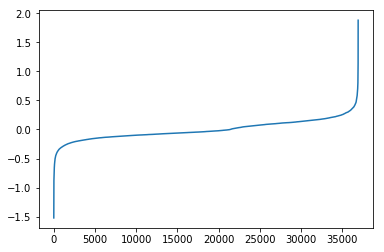

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(sorted(coef))
plt.show()

In [105]:
coef[vocabulary['dress']]

0.27289331178589837

In [110]:
coef[vocabulary['she']]

-0.35541530381124387

In [112]:
coef[vocabulary['he']]

0.46293652100681332

In [111]:
coef[vocabulary['the']]  # ?

-0.2128136378053142

## Error Analysis

- Which ones do we get wrong?
- Are there obvious reasons?